In [16]:
import tensorflow as tf
import keras

device = "cuda" if tf.config.list_physical_devices("GPU") else "cpu"

# Set memory growth for GPU
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load data

In [17]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    "../../data/OpenAnimalTracks/cropped_imgs/train",
    image_size=(224, 224),
    batch_size=16,
)
test_ds = keras.preprocessing.image_dataset_from_directory(
    "../../data/OpenAnimalTracks/cropped_imgs/test",
    image_size=(224, 224),
    batch_size=16,
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    "../../data/OpenAnimalTracks/cropped_imgs/val",
    image_size=(224, 224),
    batch_size=16,
)

Found 2514 files belonging to 18 classes.
Found 719 files belonging to 18 classes.
Found 346 files belonging to 18 classes.


In [18]:
mobilenet = keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
)

# Initially freeze the base model
mobilenet.trainable = False

# Data augmentation
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
])

# Build the complete model
model = keras.Sequential([
    data_augmentation,
    mobilenet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(18, activation="softmax"),
])

In [19]:

model.compile(optimizer="adamax", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)])

# Save the model
model.save("mobilenet.keras")

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1379 - loss: 10.8761 - val_accuracy: 0.2919 - val_loss: 9.0597
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2836 - loss: 8.8119 - val_accuracy: 0.3873 - val_loss: 7.9342
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3781 - loss: 7.7397 - val_accuracy: 0.4162 - val_loss: 7.1603
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3845 - loss: 7.0403 - val_accuracy: 0.4075 - val_loss: 6.6468
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4100 - loss: 6.4123 - val_accuracy: 0.4075 - val_loss: 6.1359
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4503 - loss: 5.8671 - val_accuracy: 0.4422 - val_loss: 5.6800
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4631 - loss: 5.4029 - val_accuracy: 0.4306 - val_loss: 5.4009
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4727 - loss: 5.0129 - val_accuracy: 

In [20]:
mobilnet = keras.models.load_model("mobilenet.keras")
mobilenet.trainable = True

fine_tune_at = len(mobilenet.layers) - 20

for layer in mobilenet.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [25]:
real_ds = keras.preprocessing.image_dataset_from_directory(
    "../../data/dataset_no_oat_downsample",
    image_size=(224, 224),
    batch_size=32,
)

Found 1105 files belonging to 13 classes.


In [26]:

train_size = int(0.8 * len(real_ds))
val_size = len(real_ds) - train_size

real_train_ds = real_ds.take(train_size)
real_val_ds = real_ds.skip(train_size)

print(f"Dataset d'entraînement: {train_size} batches")
print(f"Dataset de validation: {val_size} batches")


Dataset d'entraînement: 28 batches
Dataset de validation: 7 batches


In [27]:

print("Début du fine-tuning...")


history = mobilnet.fit(
    real_train_ds,
    epochs=60,
    validation_data=real_val_ds,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7)
    ]
)


print("Modèle fine-tuné sauvegardé sous 'mobilenet_finetuned.keras'")


Début du fine-tuning...
Epoch 1/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8201 - loss: 1.3208 - val_accuracy: 0.8612 - val_loss: 1.1503 - learning_rate: 2.5000e-04
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8370 - loss: 1.3343 - val_accuracy: 0.8900 - val_loss: 1.1720 - learning_rate: 2.5000e-04
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8407 - loss: 1.2838 - val_accuracy: 0.9187 - val_loss: 1.0648 - learning_rate: 2.5000e-04
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8394 - loss: 1.2910 - val_accuracy: 0.8134 - val_loss: 1.2804 - learning_rate: 2.5000e-04
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8443 - loss: 1.2688 - val_accuracy: 0.8708 - val_loss: 1.2227 - learning_rate: 2.5000e-04
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8392 - loss: 1.2752 - val_accuracy: 0.8230 - val_loss: 1.2881 - learning_rate: 2.5000e-04
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

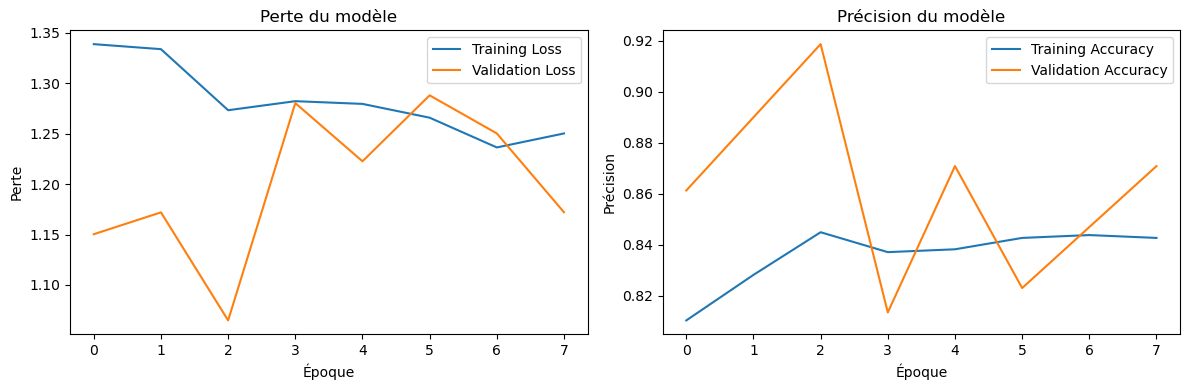

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8843 - loss: 1.1252  
Précision finale sur les données de validation: 0.8660
Perte finale sur les données de validation: 1.1524


In [29]:
# Évaluation du modèle fine-tuné
import matplotlib.pyplot as plt

# Afficher les courbes d'apprentissage
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Perte du modèle')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Précision du modèle')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()

# Évaluer sur l'ensemble de validation
val_loss, val_accuracy = mobilnet.evaluate(real_val_ds)
print(f"Précision finale sur les données de validation: {val_accuracy:.4f}")
print(f"Perte finale sur les données de validation: {val_loss:.4f}")


Classes: ['castor', 'chat', 'chien', 'coyotte', 'ecureuil', 'lapin', 'loup', 'lynx', 'ours', 'puma', 'rat', 'raton_laveur', 'renard']
Nombre de classes: 13
Génération des prédictions...
Traitement du batch 1
Traitement du batch 2
Traitement du batch 3
Traitement du batch 4
Traitement du batch 5
Traitement du batch 6
Traitement du batch 7
Total d'échantillons traités: 209
Précision finale sur les données de validation: 0.8804
Perte finale sur les données de validation: 1.1427


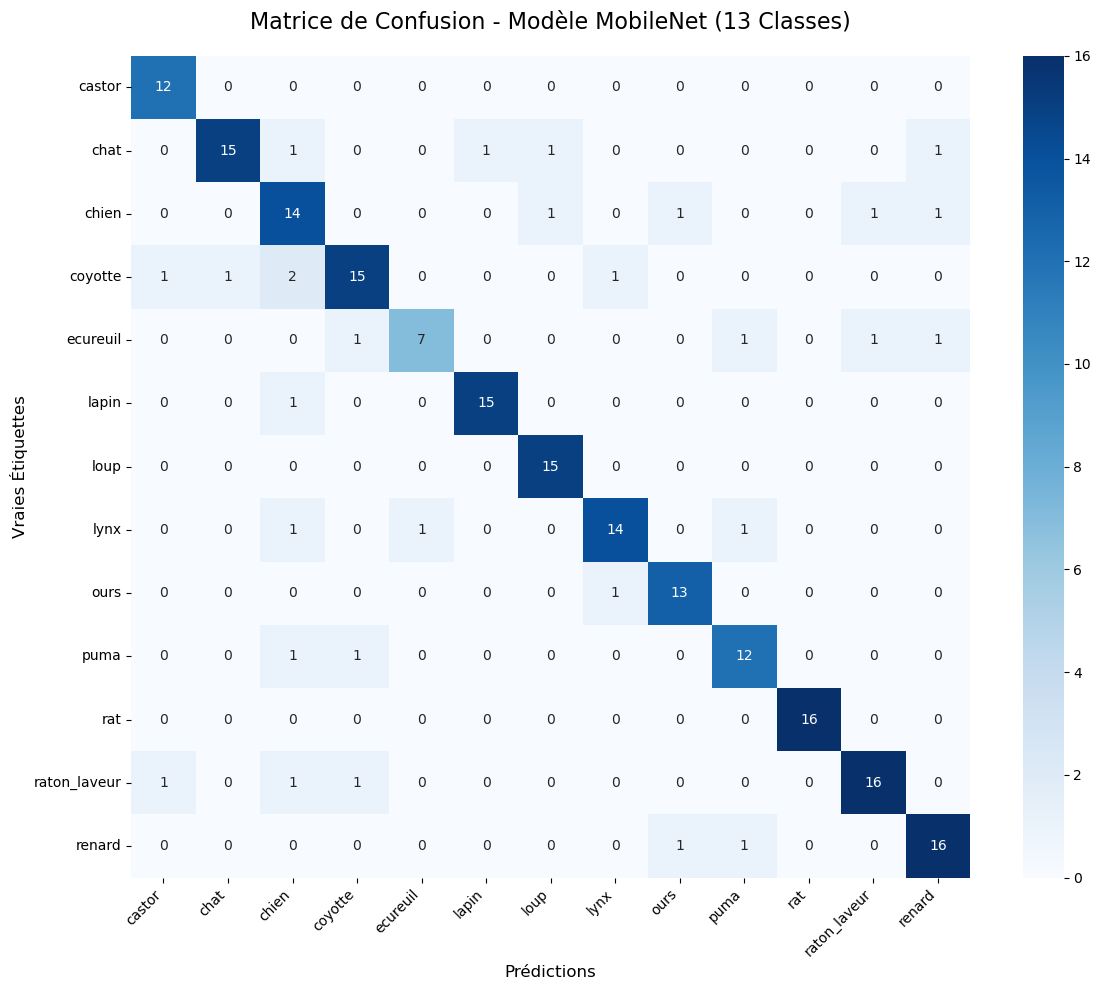


RAPPORT DE CLASSIFICATION DÉTAILLÉ
              precision    recall  f1-score   support

      castor       0.86      1.00      0.92        12
        chat       0.94      0.79      0.86        19
       chien       0.67      0.78      0.72        18
     coyotte       0.83      0.75      0.79        20
    ecureuil       0.88      0.64      0.74        11
       lapin       0.94      0.94      0.94        16
        loup       0.88      1.00      0.94        15
        lynx       0.88      0.82      0.85        17
        ours       0.87      0.93      0.90        14
        puma       0.80      0.86      0.83        14
         rat       1.00      1.00      1.00        16
raton_laveur       0.89      0.84      0.86        19
      renard       0.84      0.89      0.86        18

    accuracy                           0.86       209
   macro avg       0.87      0.86      0.86       209
weighted avg       0.87      0.86      0.86       209


Précision globale: 0.8612 (86.12%)

ERREUR

In [32]:
# Matrice de confusion sur les 13 classes

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

# Obtenir les noms des classes depuis le répertoire de données
data_dir = "../../data/dataset_no_oat_downsample"
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
print(f"Classes: {class_names}")
print(f"Nombre de classes: {len(class_names)}")

# Générer les prédictions et les vraies étiquettes
y_true = []
y_pred = []

print("Génération des prédictions...")
for batch_idx, (x, y) in enumerate(real_val_ds):
    print(f"Traitement du batch {batch_idx + 1}")
    predictions = mobilnet.predict(x, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(y.numpy())

print(f"Total d'échantillons traités: {len(y_true)}")

# Évaluer le modèle
val_loss, val_accuracy = mobilnet.evaluate(real_val_ds, verbose=0)
print(f"Précision finale sur les données de validation: {val_accuracy:.4f}")
print(f"Perte finale sur les données de validation: {val_loss:.4f}")

# Créer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Afficher la matrice de confusion avec une belle visualisation
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion - Modèle MobileNet (13 Classes)', fontsize=16, pad=20)
plt.xlabel('Prédictions', fontsize=12)
plt.ylabel('Vraies Étiquettes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculer et afficher les métriques par classe
print("\n" + "="*60)
print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))

# Calculer l'accuracy globale
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"\nPrécision globale: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Afficher les erreurs de classification les plus fréquentes
print(f"\n" + "="*40)
print("ERREURS DE CLASSIFICATION LES PLUS FRÉQUENTES")
print("="*40)

# Enlever la diagonale (prédictions correctes)
cm_errors = cm.copy()
np.fill_diagonal(cm_errors, 0)

# Trouver les 5 erreurs les plus fréquentes
flat_indices = np.argsort(cm_errors.ravel())[-5:]
row_indices, col_indices = np.unravel_index(flat_indices, cm_errors.shape)

for i in range(len(flat_indices)-1, -1, -1):
    if cm_errors[row_indices[i], col_indices[i]] > 0:
        true_class = class_names[row_indices[i]]
        pred_class = class_names[col_indices[i]]
        count = cm_errors[row_indices[i], col_indices[i]]
        print(f"{true_class} → {pred_class}: {count} erreurs")

# Afficher les performances par classe
print(f"\n" + "="*40)
print("PERFORMANCES PAR CLASSE")
print("="*40)

for i, class_name in enumerate(class_names):
    tp = cm[i, i]  # True positives
    fp = np.sum(cm[:, i]) - tp  # False positives
    fn = np.sum(cm[i, :]) - tp  # False negatives
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{class_name:20s} - Précision: {precision:.3f}, Rappel: {recall:.3f}, F1: {f1:.3f}")


In [33]:
mobilnet.save("mobilnet_masterclass.keras")

In [34]:
best_model = keras.models.load_model("mobilnet_masterclass.keras")

val_loss, val_accuracy = best_model.evaluate(real_val_ds)
print(f"Précision finale sur les données de validation: {val_accuracy:.4f}")
print(f"Perte finale sur les données de validation: {val_loss:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8872 - loss: 1.1938
Précision finale sur les données de validation: 0.8852
Perte finale sur les données de validation: 1.1725
